# Customer Segmentation with Explainable AI (LIME)

This notebook performs **customer segmentation** on a retail dataset and explains cluster assignments using **LIME (Local Interpretable Model-agnostic Explanations)**. It demonstrates a complete pipeline from preprocessing to clustering and explainable AI.

---

### **Key Highlights**
- **Data preprocessing:** Handling numeric and categorical features, scaling, and encoding.
- **Unsupervised clustering:** Using **KMeans** to segment customers.
- **Surrogate classifier:** A **Random Forest classifier** is trained on cluster labels to enable LIME explanations.
- **Explainable AI:** Using **LIME** to understand which features influence cluster assignments for individual customers.
- **Visualization:** PCA-based 2D visualization of customer segments.
- **Insights:** Cluster characteristics such as average purchase behavior, top items per cluster, and demographic patterns.

---

This notebook is **portfolio-ready** and demonstrates skills in:
- Unsupervised learning
- Feature preprocessing
- Model explainability (XAI)
- Data visualization


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular

In [2]:
df = pd.read_csv(r"C:\Users\urjam\Python\Shoppung behaviour\shopping_behavior_updated (1).csv")
df_cluster = df.drop(['Customer ID'], axis=1)  # drop ID

In [3]:
# -------------------------------
# Step 2: Convert object columns to numeric if needed
# -------------------------------
df_cluster['Frequency of Purchases'] = pd.to_numeric(df_cluster['Frequency of Purchases'], errors='coerce')
df_cluster['Discount Applied'] = df_cluster['Discount Applied'].astype(str).str.replace('%','')
df_cluster['Discount Applied'] = pd.to_numeric(df_cluster['Discount Applied'], errors='coerce')

# Fill NaNs
df_cluster[['Frequency of Purchases', 'Discount Applied']] = df_cluster[['Frequency of Purchases', 'Discount Applied']].fillna(0)

In [4]:
# -------------------------------
# Step 3: Encode categorical columns
# -------------------------------
categorical_cols = ['Gender', 'Category', 'Size', 'Color', 'Season', 'Payment Method', 'Subscription Status']
for col in categorical_cols:
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col])

In [5]:
# -------------------------------
# Step 4: Normalize numeric columns
# -------------------------------
numeric_cols = ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 
                'Frequency of Purchases', 'Review Rating', 'Discount Applied']

scaler = StandardScaler()
df_cluster[numeric_cols] = scaler.fit_transform(df_cluster[numeric_cols])

In [6]:
# -------------------------------
# Step 5: Prepare features for clustering
# -------------------------------
features_for_clustering = numeric_cols + categorical_cols
X = df_cluster[features_for_clustering]

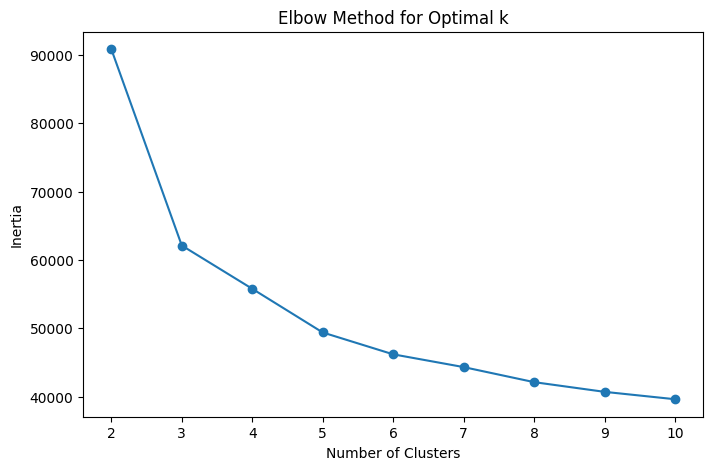

In [7]:
# -------------------------------
# Step 6: Determine optimal clusters using Elbow Method
# -------------------------------
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [8]:
# -------------------------------
# Step 7: Fit KMeans with chosen k
# -------------------------------
k = 4  # choose based on elbow
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X)

In [9]:
# -------------------------------
# Step 8: Cluster summary
# -------------------------------
cluster_numeric_features = numeric_cols + categorical_cols
cluster_summary = df_cluster.groupby('Cluster')[cluster_numeric_features].mean()
print("\nCluster summary (numeric + encoded categorical features):")
print(cluster_summary)

# Most common purchased items per cluster
for col in ['Item Purchased']:
    print(f"\nMost common {col} per cluster:")
    print(df_cluster.groupby('Cluster')[col].agg(lambda x: x.mode()[0]))


Cluster summary (numeric + encoded categorical features):
              Age  Purchase Amount (USD)  Previous Purchases  \
Cluster                                                        
0        0.073010               0.002677           -0.014509   
1        0.006931               0.043591            0.012864   
2       -0.008546              -0.012196            0.010408   
3       -0.044847              -0.048558           -0.015778   

         Frequency of Purchases  Review Rating  Discount Applied    Gender  \
Cluster                                                                      
0                           0.0       0.035817               0.0  0.684211   
1                           0.0      -0.035039               0.0  0.684626   
2                           0.0       0.010146               0.0  0.687578   
3                           0.0       0.016818               0.0  0.666052   

         Category      Size      Color    Season  Payment Method  \
Cluster            

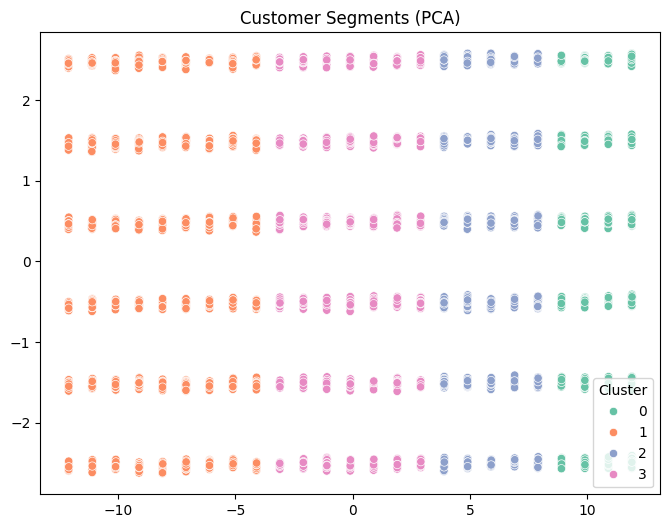

In [10]:
# -------------------------------
# Step 9: Visualize clusters with PCA
# -------------------------------
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df_cluster['Cluster'], palette='Set2')
plt.title('Customer Segments (PCA)')
plt.show()

In [11]:
#-------------------------------
# Step 10: Train surrogate classifier for LIME
# -------------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, df_cluster['Cluster'])

RandomForestClassifier(random_state=42)

In [12]:
# -------------------------------
# Step 11: LIME explanation
# -------------------------------
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=[str(i) for i in range(k)],
    mode='classification'
)

# Explain first customer
i = 0
exp = explainer.explain_instance(
    X.iloc[i].values,      # pass as numpy array
    clf.predict_proba,     # probabilities from surrogate classifier
    num_features=5
)

# Display explanation in notebook
exp.show_in_notebook(show_table=True)

# Optional: save explanation to HTML
# exp.save_to_file('lime_cluster_explanation.html')

C:\Users\urjam\venv-autogen\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
